In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.idl import readsav
from scipy.signal import find_peaks
import pickle 
from astropy.io import fits
from spectral_cube import SpectralCube
from astropy import units as u
import numpy.ma as ma
from astropy.stats import sigma_clip
import matplotlib.patheffects as path_effects
from matplotlib.gridspec import GridSpec
import mpl_toolkits.axes_grid1.axes_grid as axes_grid
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#from mpl_toolkits.axes_grid.colorbar import colorbar
from matplotlib.patches import Ellipse
import math
from matplotlib import cm
from astropy.wcs import WCS
import scipy
import scipy.ndimage as ndi
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import pkg_resources
from specutils import Spectrum1D, SpectralRegion
from astropy.modeling import models
from specutils.spectra import Spectrum1D
from specutils.fitting import fit_lines
from __future__ import print_function
import pyspeckit
import pylab as pl

block_reduce was moved to the astropy.nddata.blocks module.  Please update your import statement.


In [2]:
def gaussian_plots(globule = 'GlobC', source = '12CO'):
    path = globule + '_' + source + '.image.pbcor.fits'
    cube = fits.open(path)
    data = cube[0].data
    header = cube[0].header
    
    ra_start = header["CRVAL1"]
    ra_inc = header["CDELT1"]

    channels = np.arange(header["NAXIS1"]) - header["CRPIX1"]+1

    ra = ra_start + (ra_inc * channels)
    ra = np.array(ra, dtype = float)

    dec_start = header["CRVAL2"]
    dec_inc = header["CDELT2"]

    channels1 = np.arange(header["NAXIS2"]) - header["CRPIX2"]+1

    dec = dec_start + (dec_inc * channels1)
    dec = np.array(dec, dtype = float)
    
    if globule == 'GlobB':
        x1 = round(header["CRPIX1"]-(ra_start-337.433)/ra_inc)-1
        x2 = round(header["CRPIX1"]-(ra_start-337.427)/ra_inc)-1 
        y1 = round(header["CRPIX2"]-(dec_start+20.818)/dec_inc)-2 
        y2 = round(header["CRPIX2"]-(dec_start+20.814)/dec_inc)-2 
    elif globule == 'GlobC':
        x1 = round(header["CRPIX1"]-(ra_start-337.409)/ra_inc)-1
        x2 = round(header["CRPIX1"]-(ra_start-337.406)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+20.801)/dec_inc)-1 
        y2 = round(header["CRPIX2"]-(dec_start+20.796)/dec_inc)-1 
        
    freq_start = header["CRVAL3"]
    freq_inc = header["CDELT3"]
    
    freq_channels = np.arange(header["NAXIS3"])
    
    frequency = freq_start + (freq_inc * freq_channels)
    frequency = np.array(frequency, dtype = float)
    velocity = 3e8*(-(frequency/header["RESTFRQ"])+1)/1000
    vel_inc = velocity[1]-velocity[0]
    #print(vel_inc)
    
    data1 = data[0,:,:,:]
    data2 = data1[:, :, np.arange(x1, x2)]
    data3 = data2[:, np.arange(y1, y2), :]
    
    integrated = np.sum(data3[:, :, :], axis = 0)
 
    max_val = np.nanmax(integrated)
    
    a = [x for x in range(len(data1[:, 0, 0]))]
    array = []
    for i in range(len(a)):
        if np.nanmax(data3[a[i], :, :]) > 0*max_val:
            array.append(a[i])
            
    #print(array)

    def gaussian(x, amp, cen, sigma):
        return amp * np.exp(-(x-cen)**2 /(2*sigma**2))

    rng=range(len(velocity))
    spectrum = []
    for i in rng:
        spectrum += [np.nansum(data3[i,:,:])]

    plt.figure(figsize = (8, 5))
    plt.plot(velocity, spectrum, lw = 2, label = 'Spectrum')
    plt.title('Gaussian fits for ' + source, fontsize=20)
    plt.xlabel('Velocity km s$^{-1}$', fontsize = 12)
    plt.ylabel('Intensity (K km s$^{-1}$)', fontsize = 12)

    PIXVAL = spectrum

    peaks, properties = find_peaks(PIXVAL, height = np.amax(np.array(PIXVAL))*.5, width = 0.5) #Requirements to identify peaks
    prominences = properties["prominences"] #vertical distance between the peak and its lowest contour line
    heights = properties["peak_heights"]
    widths = properties["widths"] #width of a peak in samples
    width_heights = properties["width_heights"] #height of the contour lines at which the widths where evaluated
    #print(peaks, widths, width_heights, _["peak_heights"])
    
    x = velocity
    y = spectrum
    spectra = Spectrum1D(flux=y*u.Jy, spectral_axis=x*u.um)
    
    if globule == 'GlobB':
        gl_init = models.Gaussian1D(amplitude=15*u.Jy, mean=-19.5*u.um, stddev=0.8*u.um)
        gm_init = models.Gaussian1D(amplitude=30*u.Jy, mean=-17*u.um, stddev=0.5*u.um)
        gr_init = models.Gaussian1D(amplitude=12*u.Jy, mean=-15*u.um, stddev=0.5*u.um)
        gl_fit, gm_fit, gr_fit = fit_lines(spectra, [gl_init, gm_init, gr_init], window=[(-26*u.um, -18*u.um), (-18*u.um, -16*u.um), (-14*u.um, -10*u.um)])
    elif globule == 'GlobC':
        gl_init = models.Gaussian1D(amplitude=10*u.Jy, mean=-31*u.um, stddev=0.1*u.um)
        gm_init = models.Gaussian1D(amplitude=1.5*u.Jy, mean=-28*u.um, stddev=0.7*u.um)
        gr_init = models.Gaussian1D(amplitude=20*u.Jy, mean=-26*u.um, stddev=0.3*u.um)
        gl_fit, gm_fit, gr_fit = fit_lines(spectra, [gl_init, gm_init, gr_init], window=[(-37*u.um, -30*u.um), (-31*u.um, -23*u.um), (-26.5*u.um, -20*u.um)])
    
    yl_fit = gl_fit(x*u.um)
    ym_fit = gm_fit(x*u.um)
    yr_fit = gr_fit(x*u.um)
 
    #plt.plot(x, yl_fit, label = 'First Hyperfine Line')
    #print(gl_fit.amplitude)
    #print(gl_fit.mean)
    #print(gl_fit.stddev)
    plt.plot(x, ym_fit, label = 'Primary Gaussian')
    print(gm_fit.amplitude)
    #print((gm_fit.amplitude).shape)
    print(gm_fit.mean)
    print(gm_fit.stddev)
    #plt.plot(x, yr_fit, label = 'Second Hyperfine Line')
    #print(gr_fit.amplitude)
    #print(gr_fit.mean)
    #print(gr_fit.stddev)

    
    #for i in range(len(peaks)):
        #print('Peak '+str(i+1)+' Height: %1.2E' %(heights[i])+'(Jy/beam)')
        #print('Peak '+str(i+1)+' Velocity: %1.2f km/s' %(np.array(velocity)[peaks][i]))
        #print('Peak '+str(i+1)+' Width: %1.2f km/s' %(widths[i]))
        #print(peaks[i])
    #print(fit_info['message'])
        
    plt.grid()
    plt.legend()

Parameter('amplitude', value=9.542363365120098, unit=Jy)
Parameter('mean', value=-27.796822335680613, unit=um)
Parameter('stddev', value=0.20432212358502186, unit=um, bounds=(1.1754943508222875e-38, None))


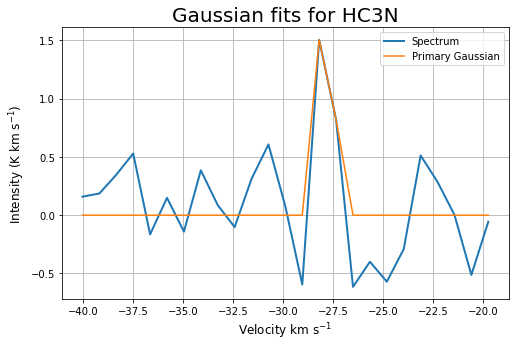

In [3]:
gaussian_plots(globule = 'GlobC', source = 'HC3N')

In [4]:
def gaussians(globule = 'GlobB', source = '12CO'):
    path = globule + '_' + source + '.image.pbcor.fits'
    cube = fits.open(path)
    data = cube[0].data
    header = cube[0].header

    ra_start = header["CRVAL1"]
    ra_inc = header["CDELT1"]

    channels = np.arange(header["NAXIS1"]) - header["CRPIX1"]+1

    ra = ra_start + (ra_inc * channels)
    ra = np.array(ra, dtype = float)

    dec_start = header["CRVAL2"]
    dec_inc = header["CDELT2"]

    channels1 = np.arange(header["NAXIS2"]) - header["CRPIX2"]+1

    dec = dec_start + (dec_inc * channels1)
    dec = np.array(dec, dtype = float)

    x1 = round(header["CRPIX1"]-(ra_start-337.409)/ra_inc)-1
    x2 = round(header["CRPIX1"]-(ra_start-337.406)/ra_inc)-1
    y1 = round(header["CRPIX2"]-(dec_start+20.801)/dec_inc)-1 
    y2 = round(header["CRPIX2"]-(dec_start+20.796)/dec_inc)-1 

    freq_start = header["CRVAL3"]
    freq_inc = header["CDELT3"]

    freq_channels = np.arange(header["NAXIS3"])

    frequency = freq_start + (freq_inc * freq_channels)
    frequency = np.array(frequency, dtype = float)
    velocity = 3e8*(-(frequency/header["RESTFRQ"])+1)/1000
    vel_inc = velocity[1]-velocity[0]
    #print(vel_inc)

    data1 = data[0,:,:,:]
    data2 = data1[:, :, np.arange(x1, x2)]
    data3 = data2[:, np.arange(y1, y2), :]

    rng=range(len(velocity))
    spectrum = []
    for i in rng:
        spectrum += [np.nansum(data3[i,:,:])]

    plt.figure(figsize = (8, 7))
    plt.plot(velocity, spectrum, lw = 2, color = 'black')
    #plt.title(source + ' Spectrum', fontsize=20)
    plt.xlabel('Velocity km s$^{-1}$', fontsize = 12)
    plt.ylabel('Intensity (K km s$^{-1}$)', fontsize = 12)

    def gaussian(x,a,x0,sigma):    
        return a*np.exp(-(x-x0)**2/(2*sigma**2))

    X = np.linspace(velocity[0], velocity[-1], 400)
    if source == 'CCH':
        plt.plot(X, gaussian(X, 4.97015, -27.91920, 0.43252), color = 'black', ls = 'dashed', alpha = 0.5)
    elif source == 'CCH_32':
        plt.plot(X, gaussian(X, 48.58054, -30.86719, 0.26415), color = 'black', ls = 'dashed', alpha = 0.5)
        plt.plot(X, gaussian(X, 66.47686, -27.99710, 0.26232), color = 'black', ls = 'dashed', alpha = 0.5)
    elif source == 'HC3N':
        plt.plot(X, gaussian(X, 1.54236, -27.96822, 0.40432), color = 'black', ls = 'dashed', alpha = 0.5)
    elif source == 'HCN':
        plt.plot(X, gaussian(X, 12.21986, -34.92187, 0.26113), color = 'black', ls = 'dashed', alpha = 0.5)
        plt.plot(X, gaussian(X, 38.96105, -27.86704, 0.27056), color = 'black', ls = 'dashed', alpha = 0.5)
        plt.plot(X, gaussian(X, 20.71648, -23.02081, 0.28796), color = 'black', ls = 'dashed', alpha = 0.5)
    elif source == 'HCN_32':
        plt.plot(X, gaussian(X, 30.02010, -30.44689, 0.18367), color = 'black', ls = 'dashed', alpha = 0.5)
        plt.plot(X, gaussian(X, 141.17922, -28.14590, 0.38295), color = 'black', ls = 'dashed', alpha = 0.5)
        plt.plot(X, gaussian(X, 38.69774, -26.47922, 0.20809), color = 'black', ls = 'dashed', alpha = 0.5)
    elif source == 'HCOp':
        plt.plot(X, gaussian(X, 35.19290, -27.90455, 0.30502), color = 'black', ls = 'dashed', alpha = 0.5)
    elif source == 'HCOp_32':
        plt.plot(X, gaussian(X, 242.76563, -27.89820, 0.28405), color = 'black', ls = 'dashed', alpha = 0.5)
    elif source == 'HNC':
        plt.plot(X, gaussian(X, 29.47175, -27.86487, 0.37175), color = 'black', ls = 'dashed', alpha = 0.5)
    elif source == 'HNC_32':
        plt.plot(X, gaussian(X, 90.38004, -27.86341, 0.35169), color = 'black', ls = 'dashed', alpha = 0.5)

    plt.grid()
    #plt.legend()

    #plt.savefig(globule + ' ' + source + ' Spectrum_May27.png', bbox_inches='tight')

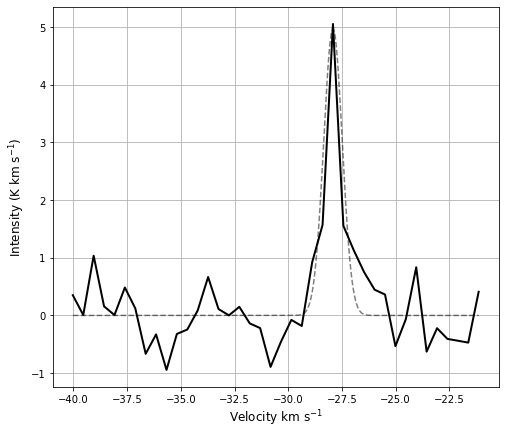

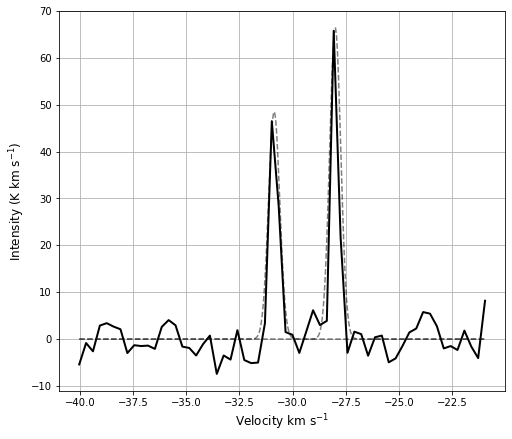

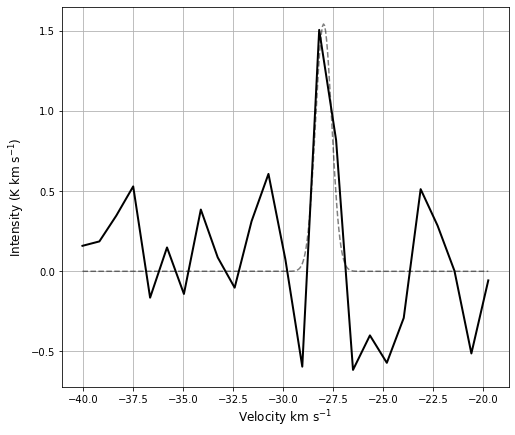

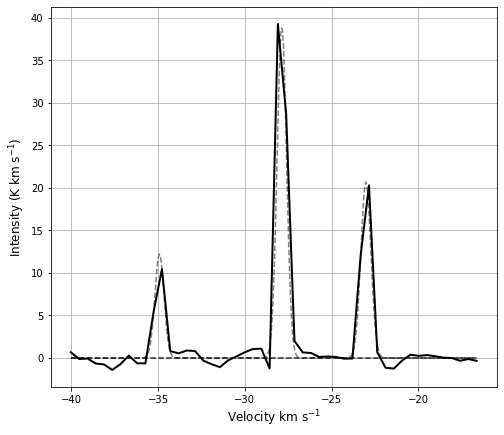

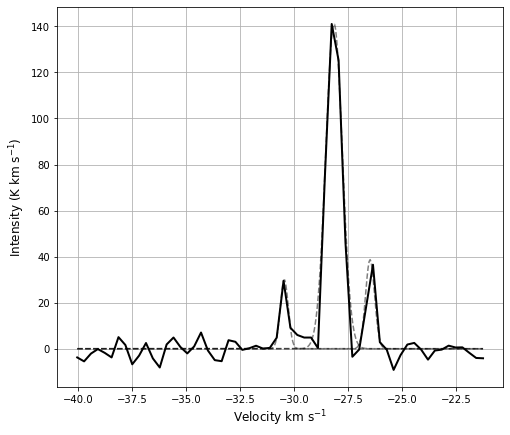

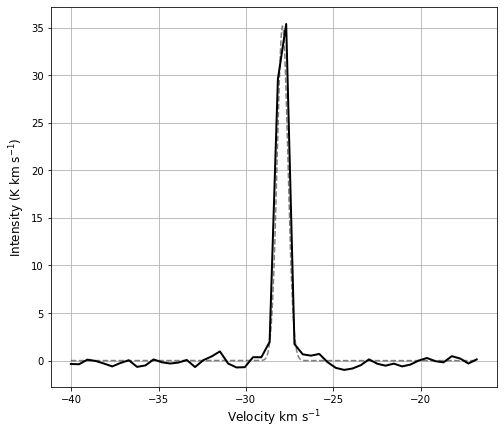

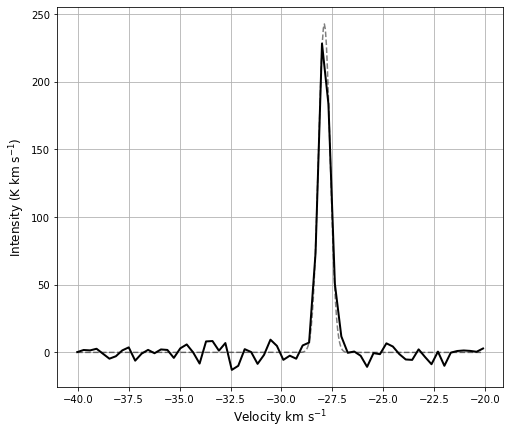

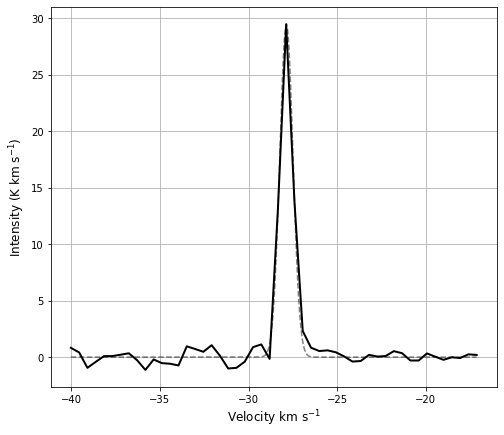

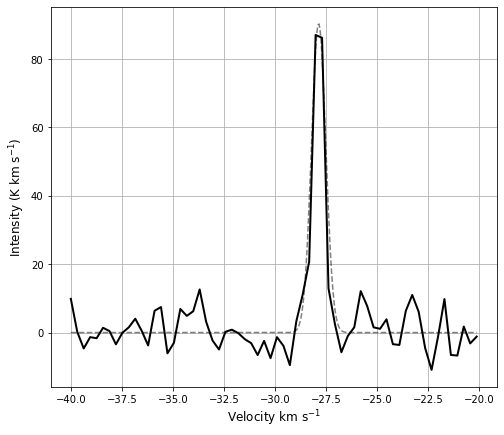

In [5]:
gaussians(globule = 'GlobC', source = 'CCH')
gaussians(globule = 'GlobC', source = 'CCH_32')
gaussians(globule = 'GlobC', source = 'HC3N')
gaussians(globule = 'GlobC', source = 'HCN')
gaussians(globule = 'GlobC', source = 'HCN_32')
gaussians(globule = 'GlobC', source = 'HCOp')
gaussians(globule = 'GlobC', source = 'HCOp_32')
gaussians(globule = 'GlobC', source = 'HNC')
gaussians(globule = 'GlobC', source = 'HNC_32')

The fit may be unsuccessful; check fit_info['message'] for more information.


Parameter('amplitude', value=97.59763934481022, unit=Jy)
Parameter('mean', value=-17.82305072535993, unit=um)
Parameter('stddev', value=0.3983394014868912, unit=um, bounds=(1.1754943508222875e-38, None))
Parameter('amplitude', value=41.75923257039437, unit=Jy)
Parameter('mean', value=-17.1927462043683, unit=um)
Parameter('stddev', value=1.1982694686918418, unit=um, bounds=(1.1754943508222875e-38, None))


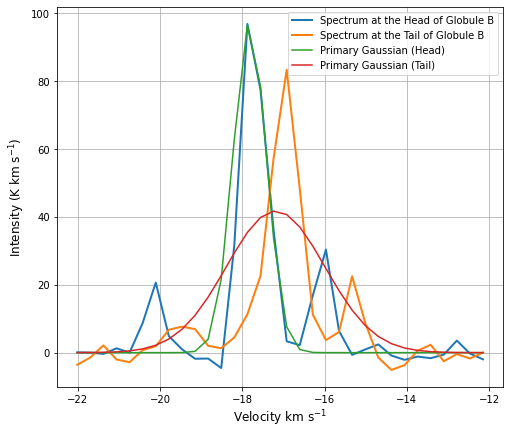

In [6]:
globule = 'GlobB'
source = 'HCN_32'

path = globule + '_' + source + '.image.pbcor.fits'
cube = fits.open(path)
data = cube[0].data
header = cube[0].header

ra_start = header["CRVAL1"]
ra_inc = header["CDELT1"]

channels = np.arange(header["NAXIS1"]) - header["CRPIX1"]+1

ra = ra_start + (ra_inc * channels)
ra = np.array(ra, dtype = float)

dec_start = header["CRVAL2"]
dec_inc = header["CDELT2"]

channels1 = np.arange(header["NAXIS2"]) - header["CRPIX2"]+1

dec = dec_start + (dec_inc * channels1)
dec = np.array(dec, dtype = float)

full_x1 = round(header["CRPIX1"]-(ra_start-337.4315)/ra_inc)-1
full_x2 = round(header["CRPIX1"]-(ra_start-337.428)/ra_inc)-1 
full_y1 = round(header["CRPIX2"]-(dec_start+20.818)/dec_inc)-2 
full_y2 = round(header["CRPIX2"]-(dec_start+20.814)/dec_inc)-2

head_x1 = round(header["CRPIX1"]-(ra_start-337.430)/ra_inc)-1
head_x2 = round(header["CRPIX1"]-(ra_start-337.428)/ra_inc)-1 
head_y1 = round(header["CRPIX2"]-(dec_start+20.818)/dec_inc)-2 
head_y2 = round(header["CRPIX2"]-(dec_start+20.816)/dec_inc)-2

tail_x1 = round(header["CRPIX1"]-(ra_start-337.4315)/ra_inc)-1
tail_x2 = round(header["CRPIX1"]-(ra_start-337.430)/ra_inc)-1 
tail_y1 = round(header["CRPIX2"]-(dec_start+20.816)/dec_inc)-2 
tail_y2 = round(header["CRPIX2"]-(dec_start+20.814)/dec_inc)-2

freq_start = header["CRVAL3"]
freq_inc = header["CDELT3"]
    
freq_channels = np.arange(header["NAXIS3"])
    
frequency = freq_start + (freq_inc * freq_channels)
frequency = np.array(frequency, dtype = float)
velocity = 3e8*(-(frequency/header["RESTFRQ"])+1)/1000
vel_inc = velocity[1]-velocity[0]
#print(vel_inc)
    
data1 = data[0,:,:,:]

full_data2 = data1[:, :, np.arange(full_x1, full_x2)]
full_data3 = full_data2[:, np.arange(full_y1, full_y2), :]
head_data2 = data1[:, :, np.arange(head_x1, head_x2)]
head_data3 = head_data2[:, np.arange(head_y1, head_y2), :]
tail_data2 = data1[:, :, np.arange(tail_x1, tail_x2)]
tail_data3 = tail_data2[:, np.arange(tail_y1, tail_y2), :]

rng=range(len(velocity))
full_spectrum = []
head_spectrum = []
tail_spectrum = []
for i in rng:
    full_spectrum += [np.nansum(full_data3[i,:,:])]
    head_spectrum += [np.nansum(head_data3[i,:,:])]
    tail_spectrum += [np.nansum(tail_data3[i,:,:])]

plt.figure(figsize = (8, 7))
plt.plot(velocity, head_spectrum, lw = 2, label = 'Spectrum at the Head of Globule B')
plt.plot(velocity, tail_spectrum, lw = 2, label = 'Spectrum at the Tail of Globule B')
#plt.title(source + ' Spectrum', fontsize=20)
plt.xlabel('Velocity km s$^{-1}$', fontsize = 12)
plt.ylabel('Intensity (K km s$^{-1}$)', fontsize = 12)

plt.grid()
plt.legend()

peaks, properties = find_peaks(head_spectrum, height = np.amax(np.array(head_spectrum))*.5, width = 0.5) #Requirements to identify peaks
prominences = properties["prominences"] #vertical distance between the peak and its lowest contour line
heights = properties["peak_heights"]
widths = properties["widths"] #width of a peak in samples
width_heights = properties["width_heights"]

x = velocity
head_y = head_spectrum
tail_y = tail_spectrum
head_spectra = Spectrum1D(flux=head_y*u.Jy, spectral_axis=x*u.um)
tail_spectra = Spectrum1D(flux=tail_y*u.Jy, spectral_axis=x*u.um)
    
head_gl_init = models.Gaussian1D(amplitude=15*u.Jy, mean=-25*u.um, stddev=0.8*u.um)
head_gm_init = models.Gaussian1D(amplitude=30*u.Jy, mean=-17*u.um, stddev=0.5*u.um)
head_gr_init = models.Gaussian1D(amplitude=12*u.Jy, mean=-13*u.um, stddev=0.5*u.um)

tail_gl_init = models.Gaussian1D(amplitude=15*u.Jy, mean=-24*u.um, stddev=0.8*u.um)
tail_gm_init = models.Gaussian1D(amplitude=26*u.Jy, mean=-16*u.um, stddev=0.25*u.um)
tail_gr_init = models.Gaussian1D(amplitude=12*u.Jy, mean=-12*u.um, stddev=0.5*u.um)

head_gl_fit, head_gm_fit, head_gr_fit = fit_lines(head_spectra, [head_gl_init, head_gm_init, head_gr_init], window=[(-26*u.um, -18*u.um), (-18*u.um, -16*u.um), (-16*u.um, -10*u.um)])
tail_gl_fit, tail_gm_fit, tail_gr_fit = fit_lines(tail_spectra, [tail_gl_init, tail_gm_init, tail_gr_init], window=[(-26*u.um, -18*u.um), (-18*u.um, -16*u.um), (-16*u.um, -10*u.um)])

head_yl_fit = head_gl_fit(x*u.um)
head_ym_fit = head_gm_fit(x*u.um)
head_yr_fit = head_gr_fit(x*u.um)

tail_yl_fit = tail_gl_fit(x*u.um)
tail_ym_fit = tail_gm_fit(x*u.um)
tail_yr_fit = tail_gr_fit(x*u.um)

#plt.plot(x, head_yl_fit, label = 'First Hyperfine Line (Head)')
#print(head_gl_fit.amplitude)
#print(head_gl_fit.mean)
#print(head_gl_fit.stddev)
plt.plot(x, head_ym_fit, label = 'Primary Gaussian (Head)')
print(head_gm_fit.amplitude)
print(head_gm_fit.mean)
print(head_gm_fit.stddev)
#plt.plot(x, head_yr_fit, label = 'Second Hyperfine Line (Head)')
#print(head_gr_fit.amplitude)
#print(head_gr_fit.mean)
#print(head_gr_fit.stddev)

#plt.plot(x, tail_yl_fit, label = 'First Hyperfine Line (Tail)')
#print(tail_gl_fit.amplitude)
#print(tail_gl_fit.mean)
#print(tail_gl_fit.stddev)
plt.plot(x, tail_ym_fit, label = 'Primary Gaussian (Tail)')
print(tail_gm_fit.amplitude)
print(tail_gm_fit.mean)
print(tail_gm_fit.stddev)
#print(tail_gm_fit.fwhm)
#plt.plot(x, tail_yr_fit, label = 'Second Hyperfine Line (Tail)')
#print(tail_gr_fit.amplitude)
#print(tail_gr_fit.mean)
#print(tail_gr_fit.stddev)

plt.legend()

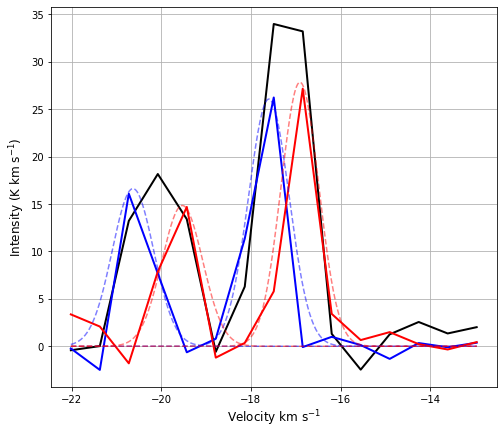

In [11]:
plt.figure(figsize = (8, 7))
plt.plot(velocity, full_spectrum, lw = 2, color = 'black')
plt.plot(velocity, head_spectrum, lw = 2, color = 'blue')
plt.plot(velocity, tail_spectrum, lw = 2, color = 'red')

def gaussian(x,a,x0,sigma):    
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

X = np.linspace(velocity[0], velocity[-1], 400)
if source == '12CO':
    plt.plot(X, gaussian(X, 336.69608, -17.43522, 0.31757), color = 'blue', alpha = 0.5, ls = 'dashed')
    plt.plot(X, gaussian(X, 520.37136, -16.58771, 0.35846), color = 'red', alpha = 0.5, ls = 'dashed')
elif source == '13CO':
    plt.plot(X, gaussian(X, 195.84384, -17.48645, 0.22216), color = 'blue', alpha = 0.5, ls = 'dashed')
    plt.plot(X, gaussian(X, 224.64920, -16.64954, 0.26948), color = 'red', alpha = 0.5, ls = 'dashed')
elif source == 'C18O':
    plt.plot(X, gaussian(X, 20.68004, -17.54416, 0.25073), color = 'blue', alpha = 0.5, ls = 'dashed')
    plt.plot(X, gaussian(X, 12.02302, -16.66806, 0.28141), color = 'red', alpha = 0.5, ls = 'dashed')
elif source == 'CCH':
    plt.plot(X, gaussian(X, 3.79644, -17.35329, 0.24327), color = 'blue', alpha = 0.5, ls = 'dashed')
    plt.plot(X, gaussian(X, 3.71644, -16.35329, 0.24327), color = 'red', alpha = 0.5, ls = 'dashed')
elif source == 'CCH_32':
    plt.plot(X, gaussian(X, 16.62821, -20.62955, 0.46308), color = 'blue', alpha = 0.5, ls = 'dashed')
    plt.plot(X, gaussian(X, 26.07750, -17.59973, 0.45228), color = 'blue', alpha = 0.5, ls = 'dashed')
    plt.plot(X, gaussian(X, 14.85138, -19.52878, 0.45573), color = 'red', alpha = 0.5, ls = 'dashed')
    plt.plot(X, gaussian(X, 27.85138, -16.90560, 0.42117), color = 'red', alpha = 0.5, ls = 'dashed')
elif source == 'HC3N':
    plt.plot(X, gaussian(X, 1.72858, -17.50657, 0.50242), color = 'blue', alpha = 0.5, ls = 'dashed')
    plt.plot(X, gaussian(X, 1.01177, -16.60560, 0.62117), color = 'red', alpha = 0.5, ls = 'dashed')
elif source == 'HCN':
    plt.plot(X, gaussian(X, 7.44815, -24.64394, 0.25235), color = 'blue', alpha = 0.5, ls = 'dashed')
    plt.plot(X, gaussian(X, 21.31026, -17.48379, 0.26311), color = 'blue', alpha = 0.5, ls = 'dashed')
    plt.plot(X, gaussian(X, 11.85025, -12.70767, 0.25211), color = 'blue', alpha = 0.5, ls = 'dashed')
    plt.plot(X, gaussian(X, 6.93481, -23.71117, 0.28697), color = 'red', alpha = 0.5, ls = 'dashed')
    plt.plot(X, gaussian(X, 24.48297, -16.65596, 0.27858), color = 'red', alpha = 0.5, ls = 'dashed')
    plt.plot(X, gaussian(X, 11.75178, -11.76566, 0.28615), color = 'red', alpha = 0.5, ls = 'dashed')
elif source == 'HCN_32':
    plt.plot(X, gaussian(X, 21.03130, -20.14556, 0.20958), color = 'blue', alpha = 0.5, ls = 'dashed')
    plt.plot(X, gaussian(X, 97.59768, -17.82304, 0.39833), color = 'blue', alpha = 0.5, ls = 'dashed')
    plt.plot(X, gaussian(X, 30.79582, -16.05182, 0.19252), color = 'blue', alpha = 0.5, ls = 'dashed')
    plt.plot(X, gaussian(X, 8.21939, -19.44630, 0.42550), color = 'red', alpha = 0.5, ls = 'dashed')
    plt.plot(X, gaussian(X, 81.33719, -16.96914, 0.35952), color = 'red', alpha = 0.5, ls = 'dashed')
    plt.plot(X, gaussian(X, 22.65247, -15.31004, 0.21273), color = 'red', alpha = 0.5, ls = 'dashed')
elif source == 'HCOp':
    plt.plot(X, gaussian(X, 21.69666, -17.45312, 0.35063), color = 'blue', alpha = 0.5, ls = 'dashed')
    plt.plot(X, gaussian(X, 27.20079, -16.61883, 0.30976), color = 'red', alpha = 0.5, ls = 'dashed')
elif source == 'HCOp_32':
    plt.plot(X, gaussian(X, 132.41024, -17.52543, 0.31796), color = 'blue', alpha = 0.5, ls = 'dashed')
    plt.plot(X, gaussian(X, 121.96131, -16.61593, 0.25512), color = 'red', alpha = 0.5, ls = 'dashed')
elif source == 'HNC':
    plt.plot(X, gaussian(X, 18.71873, -17.49260, 0.38634), color = 'blue', alpha = 0.5, ls = 'dashed')
    plt.plot(X, gaussian(X, 17.08114, -16.63597, 0.33661), color = 'red', alpha = 0.5, ls = 'dashed')
elif source == 'HNC_32':
    plt.plot(X, gaussian(X, 70.45435, -17.43446, 0.30452), color = 'blue', alpha = 0.5, ls = 'dashed')
    plt.plot(X, gaussian(X, 45.08417, -16.61815, 0.29576), color = 'red', alpha = 0.5, ls = 'dashed')
    

#plt.legend()
plt.xlabel('Velocity km s$^{-1}$', fontsize = 12)
plt.ylabel('Intensity (K km s$^{-1}$)', fontsize = 12)
plt.grid()

#plt.savefig(globule + ' ' + source + ' Spectrum_May27.png', bbox_inches='tight')